In [1]:
# Here we explore feature importance modules provided by captum using toy datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

x, y = make_classification(
    n_samples=600,
    n_features=10,
    n_informative=4,
    n_redundant=0,
    n_repeated=0,
    n_classes=4,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=False,
    random_state=0,
)

In [2]:
feature_names = [f"x{i}" for i in range(1, x.shape[1] + 1)]
df = pd.DataFrame(x, columns=feature_names)
df["y"] = y

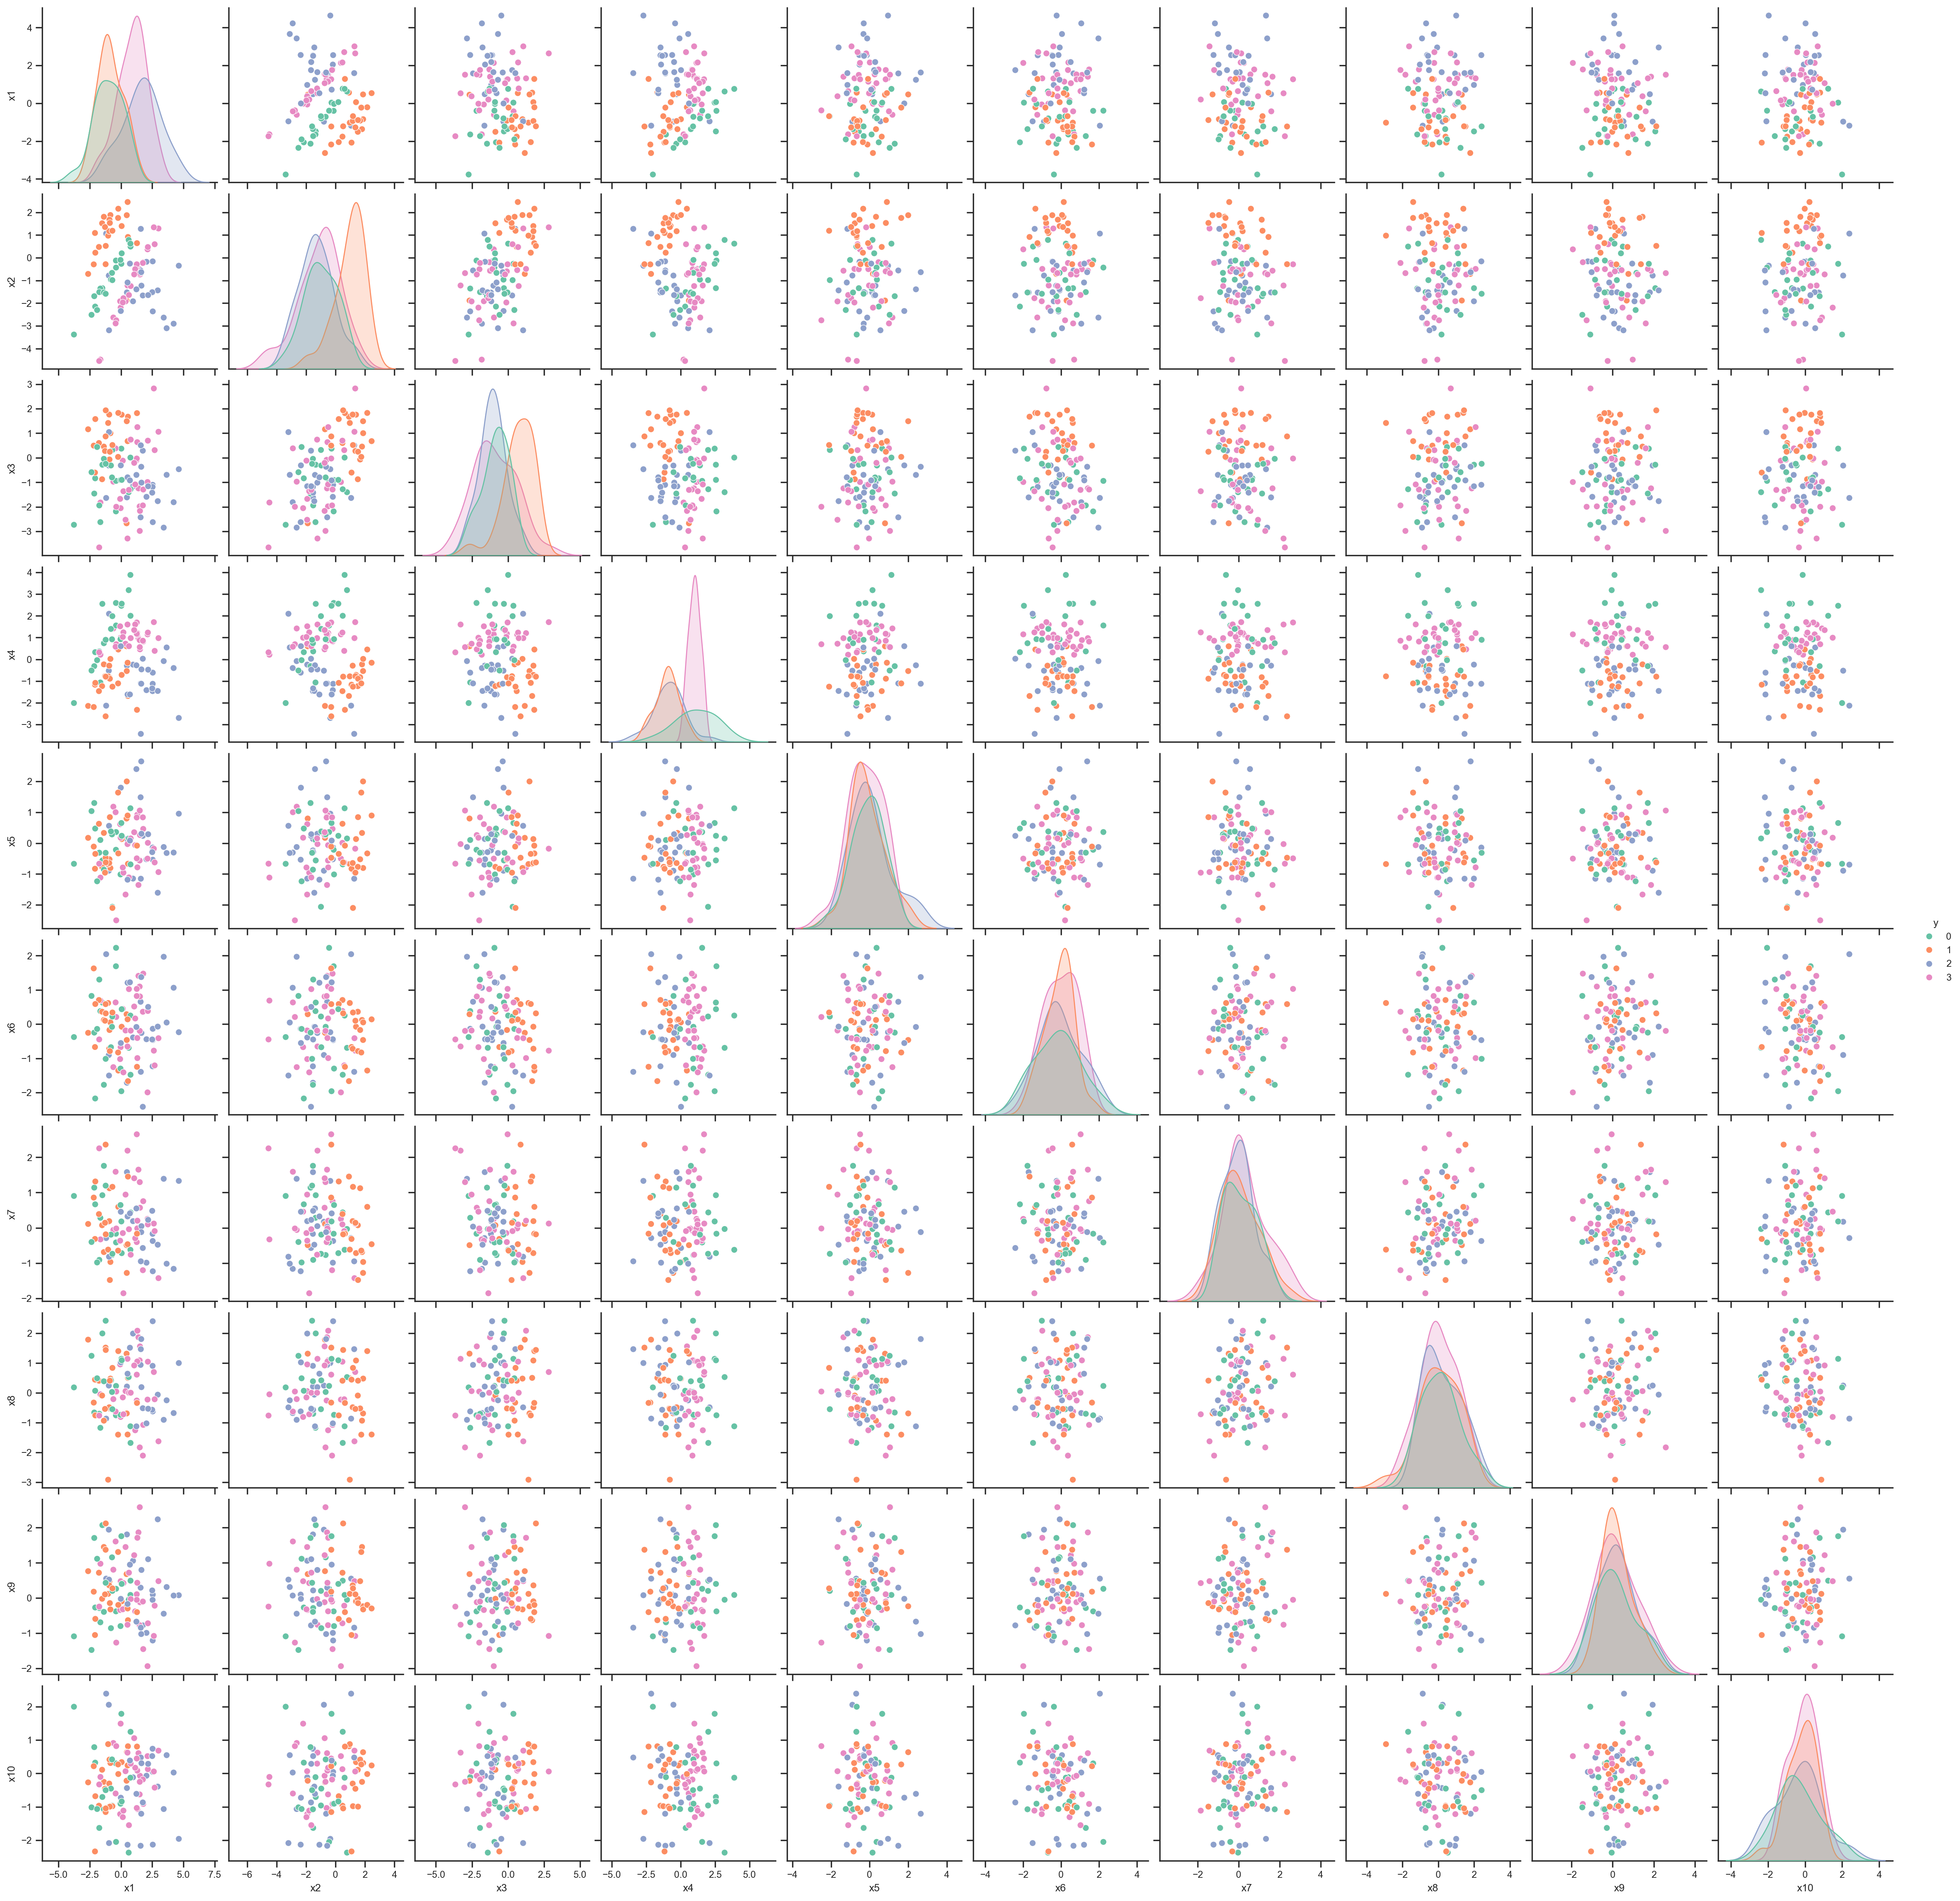

In [3]:
# create pair plot
# sample 100 random samples and plot
df_sample = df.sample(100)
sns.pairplot(df_sample, hue="y", palette="Set2")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from captum.attr import DeepLift, FeatureAblation, GradientShap, IntegratedGradients, NoiseTunnel

In [5]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

In [6]:
torch.manual_seed(1234)
np.random.seed(1234)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [7]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).view(-1, 1).long()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).view(-1, 1).long()

datasets = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [8]:
class Model(nn.Module):
    def __init__(self, input_size=10, n_classes=4):
        super().__init__()
        self.lin1 = nn.Linear(input_size, size_hidden1)
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.lin4 = nn.Linear(size_hidden3, n_classes)
        self.gelu = nn.GELU()

    def forward(self, input):
        x = self.gelu(self.lin1(input))
        x = self.gelu(self.lin2(x))
        x = self.gelu(self.lin3(x))
        logits = self.gelu(self.lin4(x))
        return logits


model = Model(input_size=x.shape[1], n_classes=np.unique(y).size)
model.train()

Model(
  (lin1): Linear(in_features=10, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (lin4): Linear(in_features=10, out_features=4, bias=True)
  (gelu): GELU(approximate='none')
)

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def eval_stats(model_inp, x_test, y_test):
    model_inp.eval()
    with torch.no_grad():
        outputs = model_inp(x_test)
        _, predicted = torch.max(outputs.data, 1)

        total = y_test.size(0)
        correct = (predicted == y_test.view(-1)).sum().item()
        print("Accuracy of the network on the test set: %d %%" % (100 * correct / total))


def train(model_inp, num_epochs=num_epochs):
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            outputs = model_inp(inputs)
            loss = criterion(outputs, labels.view(-1))
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
        if epoch % 20 == 0:
            eval_stats(model, x_test, y_test)
            print(
                "Epoch [%d]/[%d] running accumulative loss across all batches: %.3f"
                % (epoch + 1, num_epochs, running_loss)
            )
        running_loss = 0.0

In [11]:
train(model)

Accuracy of the network on the test set: 37 %
Epoch [1]/[200] running accumulative loss across all batches: 58.166
Accuracy of the network on the test set: 87 %
Epoch [21]/[200] running accumulative loss across all batches: 20.388
Accuracy of the network on the test set: 91 %
Epoch [41]/[200] running accumulative loss across all batches: 10.764
Accuracy of the network on the test set: 92 %
Epoch [61]/[200] running accumulative loss across all batches: 8.595
Accuracy of the network on the test set: 92 %
Epoch [81]/[200] running accumulative loss across all batches: 7.250
Accuracy of the network on the test set: 93 %
Epoch [101]/[200] running accumulative loss across all batches: 6.367
Accuracy of the network on the test set: 92 %
Epoch [121]/[200] running accumulative loss across all batches: 5.633
Accuracy of the network on the test set: 92 %
Epoch [141]/[200] running accumulative loss across all batches: 5.009
Accuracy of the network on the test set: 92 %
Epoch [161]/[200] running acc

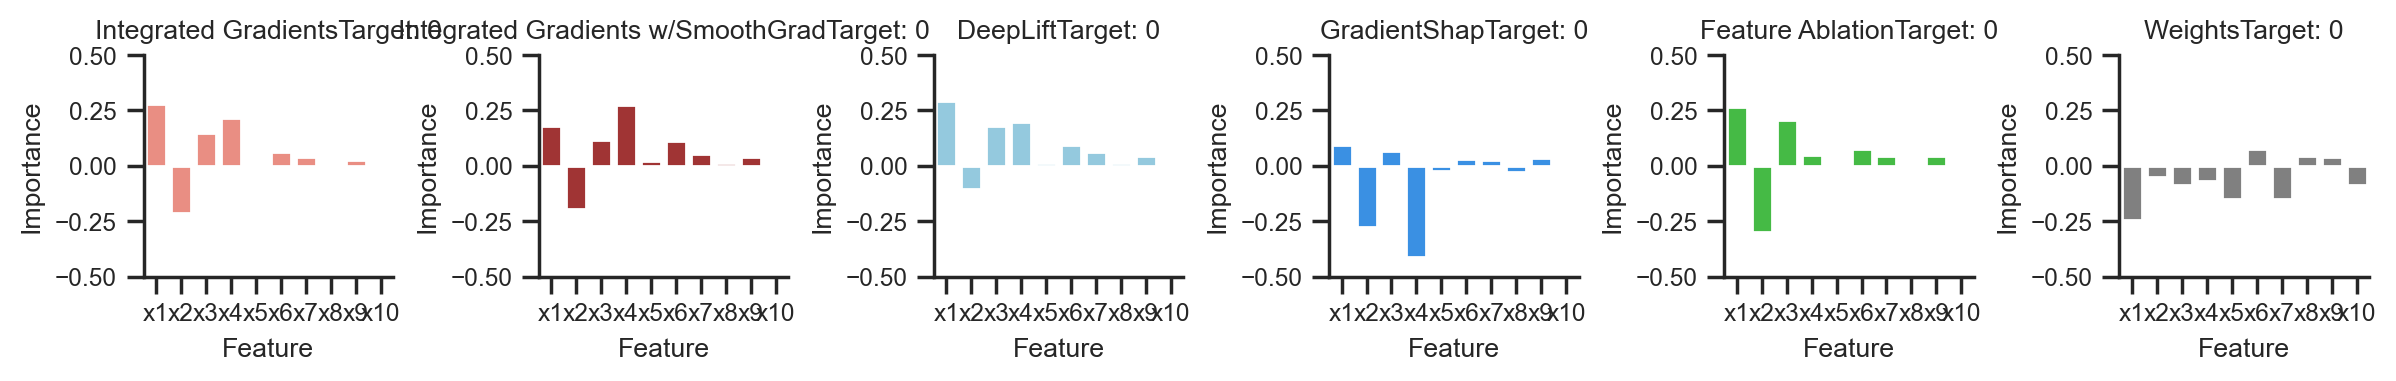

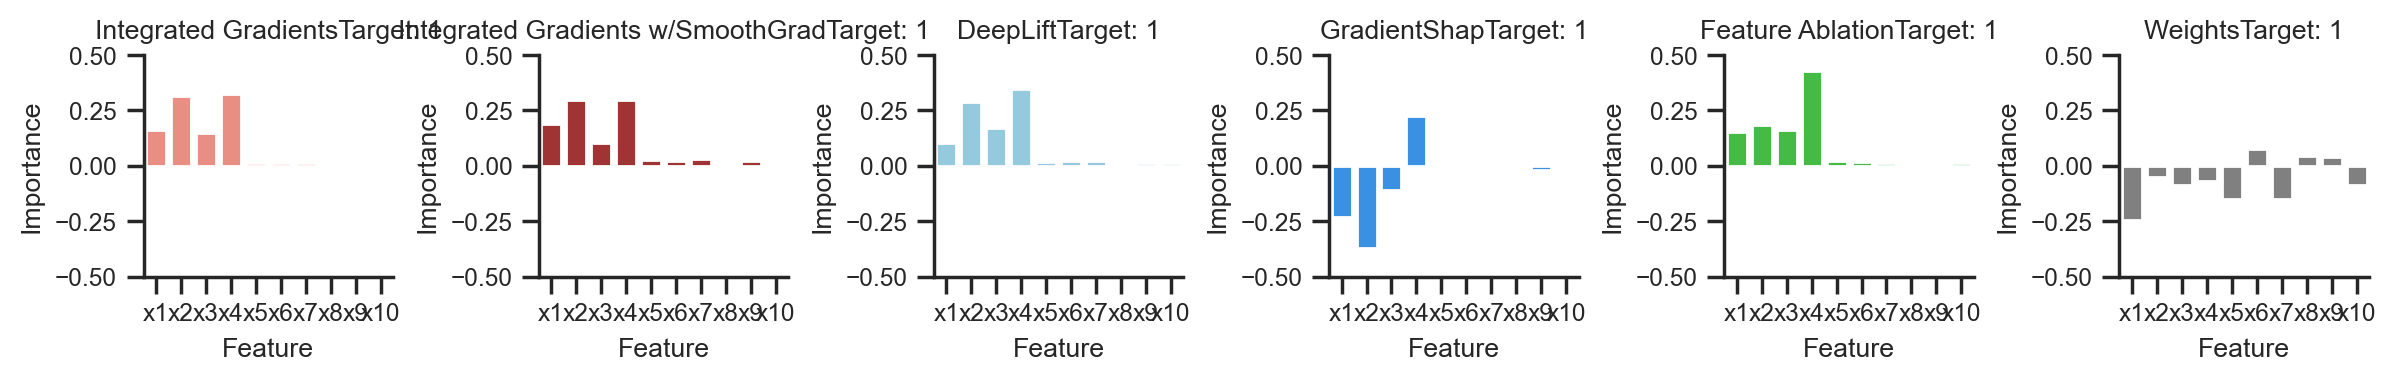

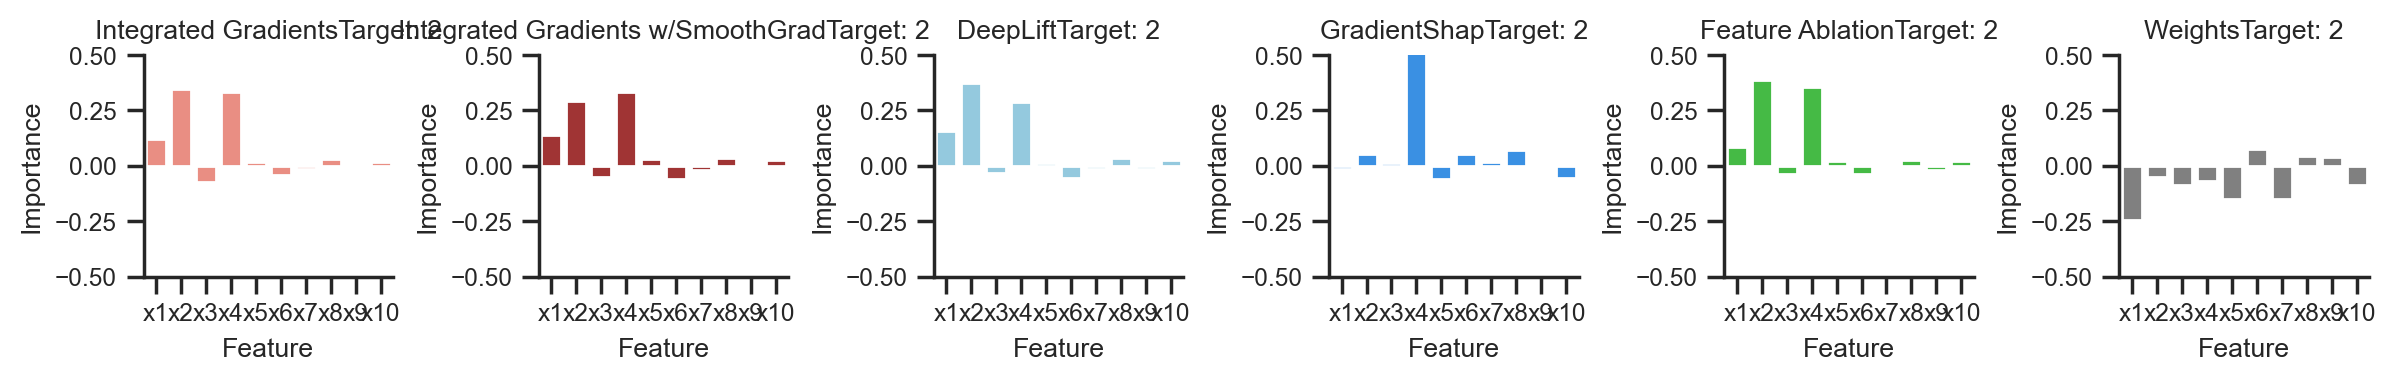

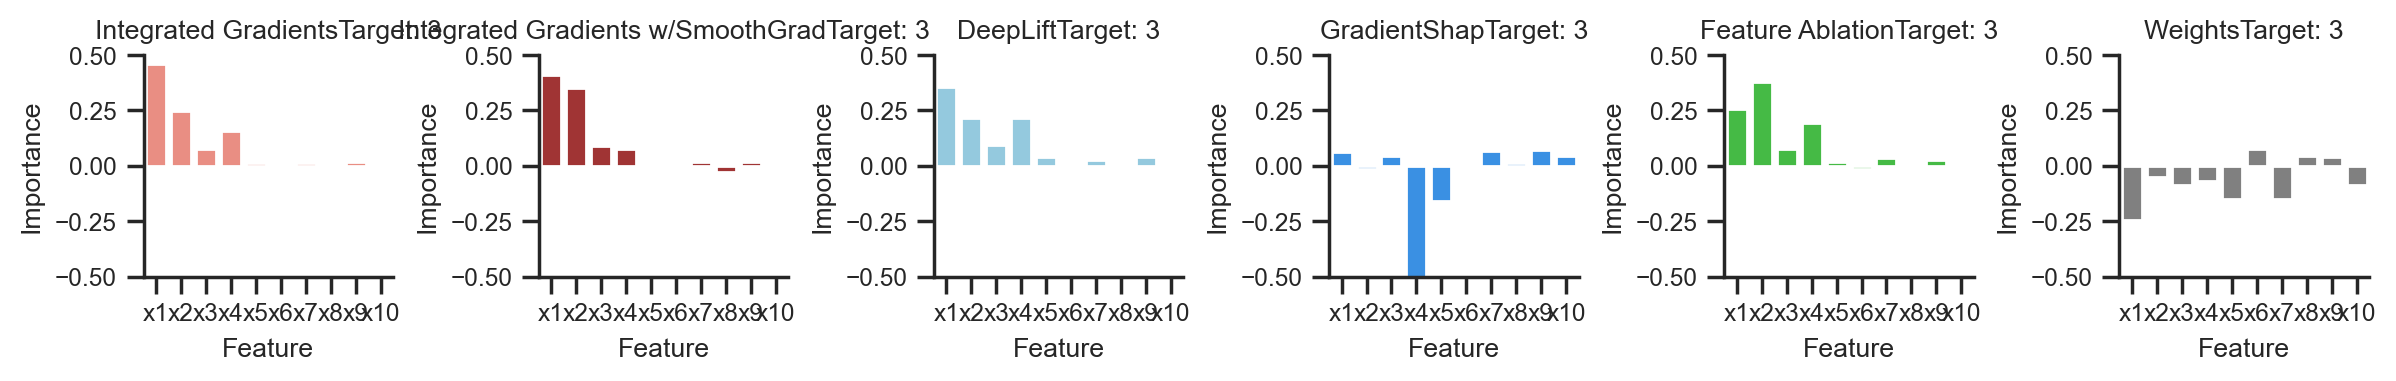

In [12]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="captum._utils.gradient")
warnings.filterwarnings("ignore", category=UserWarning, module="captum.attr._core.deep_lift")


ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

colors_map = {
    "Integrated Gradients": "salmon",
    "Integrated Gradients w/SmoothGrad": "firebrick",
    "DeepLift": "skyblue",
    "GradientShap": "dodgerblue",
    "Feature Ablation": "limegreen",
    "Weights": "grey",
}


def normalize_attr(attr):
    """sums the attribute values across samples for each feature and normalizes them by the L1 norm"""
    attr_sum = attr.detach().numpy().sum(0)
    return attr_sum / np.linalg.norm(attr_sum, ord=1)


for target_class in torch.unique(y_test):
    ig_attr_test = ig.attribute(x_test, target=target_class, n_steps=50)
    ig_nt_attr_test = ig_nt.attribute(x_test, target=target_class)
    dl_attr_test = dl.attribute(x_test, target=target_class)
    gs_attr_test = gs.attribute(x_test, x_train, target=target_class)
    fa_attr_test = fa.attribute(x_test, target=target_class)

    ig_attr_test_norm_sum = normalize_attr(ig_attr_test)
    ig_nt_attr_test_norm_sum = normalize_attr(ig_nt_attr_test)
    dl_attr_test_norm_sum = normalize_attr(dl_attr_test)
    gs_attr_test_norm_sum = normalize_attr(gs_attr_test)
    fa_attr_test_norm_sum = normalize_attr(fa_attr_test)

    lin_weight = model.lin1.weight[0].detach().numpy()
    y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

    df_results = pd.DataFrame({
        "feature": feature_names,
        "Integrated Gradients": ig_attr_test_norm_sum,
        "Integrated Gradients w/SmoothGrad": ig_nt_attr_test_norm_sum,
        "DeepLift": dl_attr_test_norm_sum,
        "GradientShap": gs_attr_test_norm_sum,
        "Feature Ablation": fa_attr_test_norm_sum,
        "Weights": y_axis_lin_weight,
    })

    method_names = df_results.columns.tolist()
    method_names = method_names[1:]
    df_results_pivot = df_results.melt(
        id_vars=["feature"], value_vars=method_names, var_name="method", value_name="value"
    )
    # display(df_results_pivot.head(3))

    # plot a bar plot using df_results per method
    f, ax = plt.subplots(1, len(method_names), figsize=(12, 2))
    for i, method in enumerate(method_names):
        sns.barplot(
            x="feature",
            y="value",
            data=df_results_pivot[df_results_pivot["method"] == method],
            color=colors_map[method],
            ax=ax[i],
        )
        ax[i].set(
            xlabel="Feature", ylabel="Importance", title=method + f"Target: {target_class.item()}", ylim=(-0.5, 0.5)
        )
    plt.tight_layout()
    plt.show()